In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

In [ ]:
!pip install -q ultralytics imutils

In [ ]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [ ]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [20]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [29]:
import yaml
import os

# =================================================================
# BƯỚC 1: ĐẢM BẢO FILE YAML VÀ DATASET.YAML ĐƯỢC TẠO
# =================================================================

# Tạo data.yaml
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}
with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)

# =================================================================
# BƯỚC 2: ĐỊNH NGHĨA MODEL_DICT (ĐÃ SỬA LỖI P5 CUỐI CÙNG)
# =================================================================
model_dict = {
    "nc": 5,

    # Layer 0: Load MobileNetV2 via Torchvision (Kết thúc ở Index 16, 160 kênh)
    "backbone": [
        [-1, 1, "TorchVision", [1280, "mobilenet_v2", "DEFAULT", True, 2, True]], # backbone index 0
        [-1, 1, "nn.Identity", []], # index 1
        [-1, 1, "nn.Identity", []], # index 2

        # ------ P3 Branch (target: 256 channels)
        # (Đã đúng) Tap Index 6 (stride 8) -> 32 channels
        [0, 1, "Index", [32, 6]], # index 3
        [-1, 1, "Conv", [256, 1, 1]], # project from 32 to 256
        [-1, 1, "nn.Identity", []], # pin this as backbone index 5 (p3)

        # --------- P4 Branch (target: 512 channels)
        # (Đã đúng) Tap Index 13 (stride 16) -> 96 channels
        [0, 1, "Index", [96, 13]], # index 6
        [-1, 1, "Conv", [512, 1, 1]], # project from 96 to 512
        [-1, 1, "nn.Identity", []],# pin this as backbone index 8 (P4)

        # ------------------------- P5 Branch (target: 1024 channels)
        # SỬA LỖI: Tap Index 16 (stride 32) -> 160 channels
        [0, 1, "Index", [160, 16]], # index 9
        # SỬA LỖI: Project 160 -> 1024
        [-1, 1, "Conv", [1024, 1, 1]], # index 10 (project from 160 to 1024)
        [-1, 1, "SPPF", [1024, 5]] # SPPF block finalizes p5 -> backbone index 11
    ],
    
    # Head (Giữ nguyên, giờ sẽ nhận đúng input)
    "head": [
        [-1, 1, "nn.Upsample", [None, 2, "nearest"]], # index 12 (from 11)
        [[-1, 8], 1, "Concat", [1]], # Concatenate upsampled P5 with P4 (backbone index 8)
        [-1, 3, "C2f", [512, True]], # index 14

        [-1, 1, "nn.Upsample", [None, 2, "nearest"]], # index 15 (from 14)
        [[-1, 5], 1, "Concat", [1]], # Concatenate upsampled P4 with P3 (backbone index 5)
        [-1, 3, "C2f", [256, True]], # index 17

        [-1, 1, "Conv", [256, 3, 2]], # index 18 (from 17)
        [[-1, 14], 1, "Concat", [1]], # Concat with C2f output from index 14
        [-1, 3, "C2f", [512, True]], # index 20

        [-1, 1, "Conv", [512, 3, 2]], # index 21 (from 20)
        [[-1, 11], 1, "Concat", [1]], # Concatenate with P5 (backbone index 11)
        [-1, 3, "C2f", [1024, True]], # index 23

        [[17, 20, 23], 1, "Detect", ["nc"]] # Detect from 17, 20, 23
    ]
}

# =================================================================
# BƯỚC 3: XÓA FILE CŨ (NẾU CÓ) VÀ GHI FILE MỚI
# =================================================================
yaml_path = "/kaggle/working/yolov8-custom.yaml"
if os.path.exists(yaml_path):
    os.remove(yaml_path)
    print(f"Đã xóa file .yaml cũ: {yaml_path}")

with open(yaml_path, "w") as f:
    yaml.dump(model_dict, f, sort_keys=False)

print(f"Đã tạo file .yaml mới (đã sửa lỗi P5 lần cuối) tại: {yaml_path}")

Đã xóa file .yaml cũ: /kaggle/working/yolov8-custom.yaml
Đã tạo file .yaml mới (đã sửa lỗi P5 lần cuối) tại: /kaggle/working/yolov8-custom.yaml


In [30]:
from ultralytics import YOLO

yolo_efficientnet_model = YOLO('/kaggle/working/yolov8-custom.yaml')

In [31]:
yolo_efficientnet_train = yolo_efficientnet_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 16)

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/yolov8-custom.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

In [33]:
!ls -l /kaggle/working/runs/detect/

total 4
drwxr-xr-x 3 root root 4096 Nov 15 03:58 train


In [34]:
best_efficientnet_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [35]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [36]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/BoxP_curve.png (deflated 9%)
  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/weights/best.pt (deflated 9%)
  adding: runs/detect/train/weights/last.pt (deflated 9%)
  adding: runs/detect/train/val_batch0_labels.jpg (deflated 7%)
  adding: runs/detect/train/train_batch0.jpg (deflated 4%)
  adding: runs/detect/train/labels.jpg (deflated 27%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/results.png (deflated 8%)
  adding: runs/detect/train/BoxR_curve.png (deflated 9%)
  adding: runs/detect/train/train_batch5041.jpg (deflated 13%)
  adding: runs/detect/train/confusion_matrix.png (deflated 25%)
  adding: runs/detect/train/args.yaml (deflated 53%)
  adding: runs/detect/train/train_batch1.jpg (deflated 4%)
  adding: runs/detect/train/val_batch1_pred.jpg (deflated 7%)
  adding: runs/detect/train/va

In [37]:
!ls -lh /kaggle/working/


total 164M
-rw-r--r-- 1 root root  325 Nov 15 02:34 dataset.yaml
drwxr-xr-x 3 root root 4.0K Nov 15 02:34 runs
-rw-r--r-- 1 root root 159M Nov 15 04:11 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 15 02:34 yolo11n.pt
-rw-r--r-- 1 root root 1.2K Nov 15 02:34 yolov8-custom.yaml


# Inference on Test Images


In [38]:
results = best_efficientnet_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 1 Person, 10 Cars, 54.6ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 9 Cars, 19.3ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 13 Cars, 18.9ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 3 Cars, 18.8ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 2 Persons, 19.0ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 2 Persons, 18.9ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x640 5 Persons, 19.0ms
image 8/571 

In [39]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




In [ ]:
show_random_result(results)

In [ ]:
show_random_result(results)

In [ ]:

show_random_result(results)

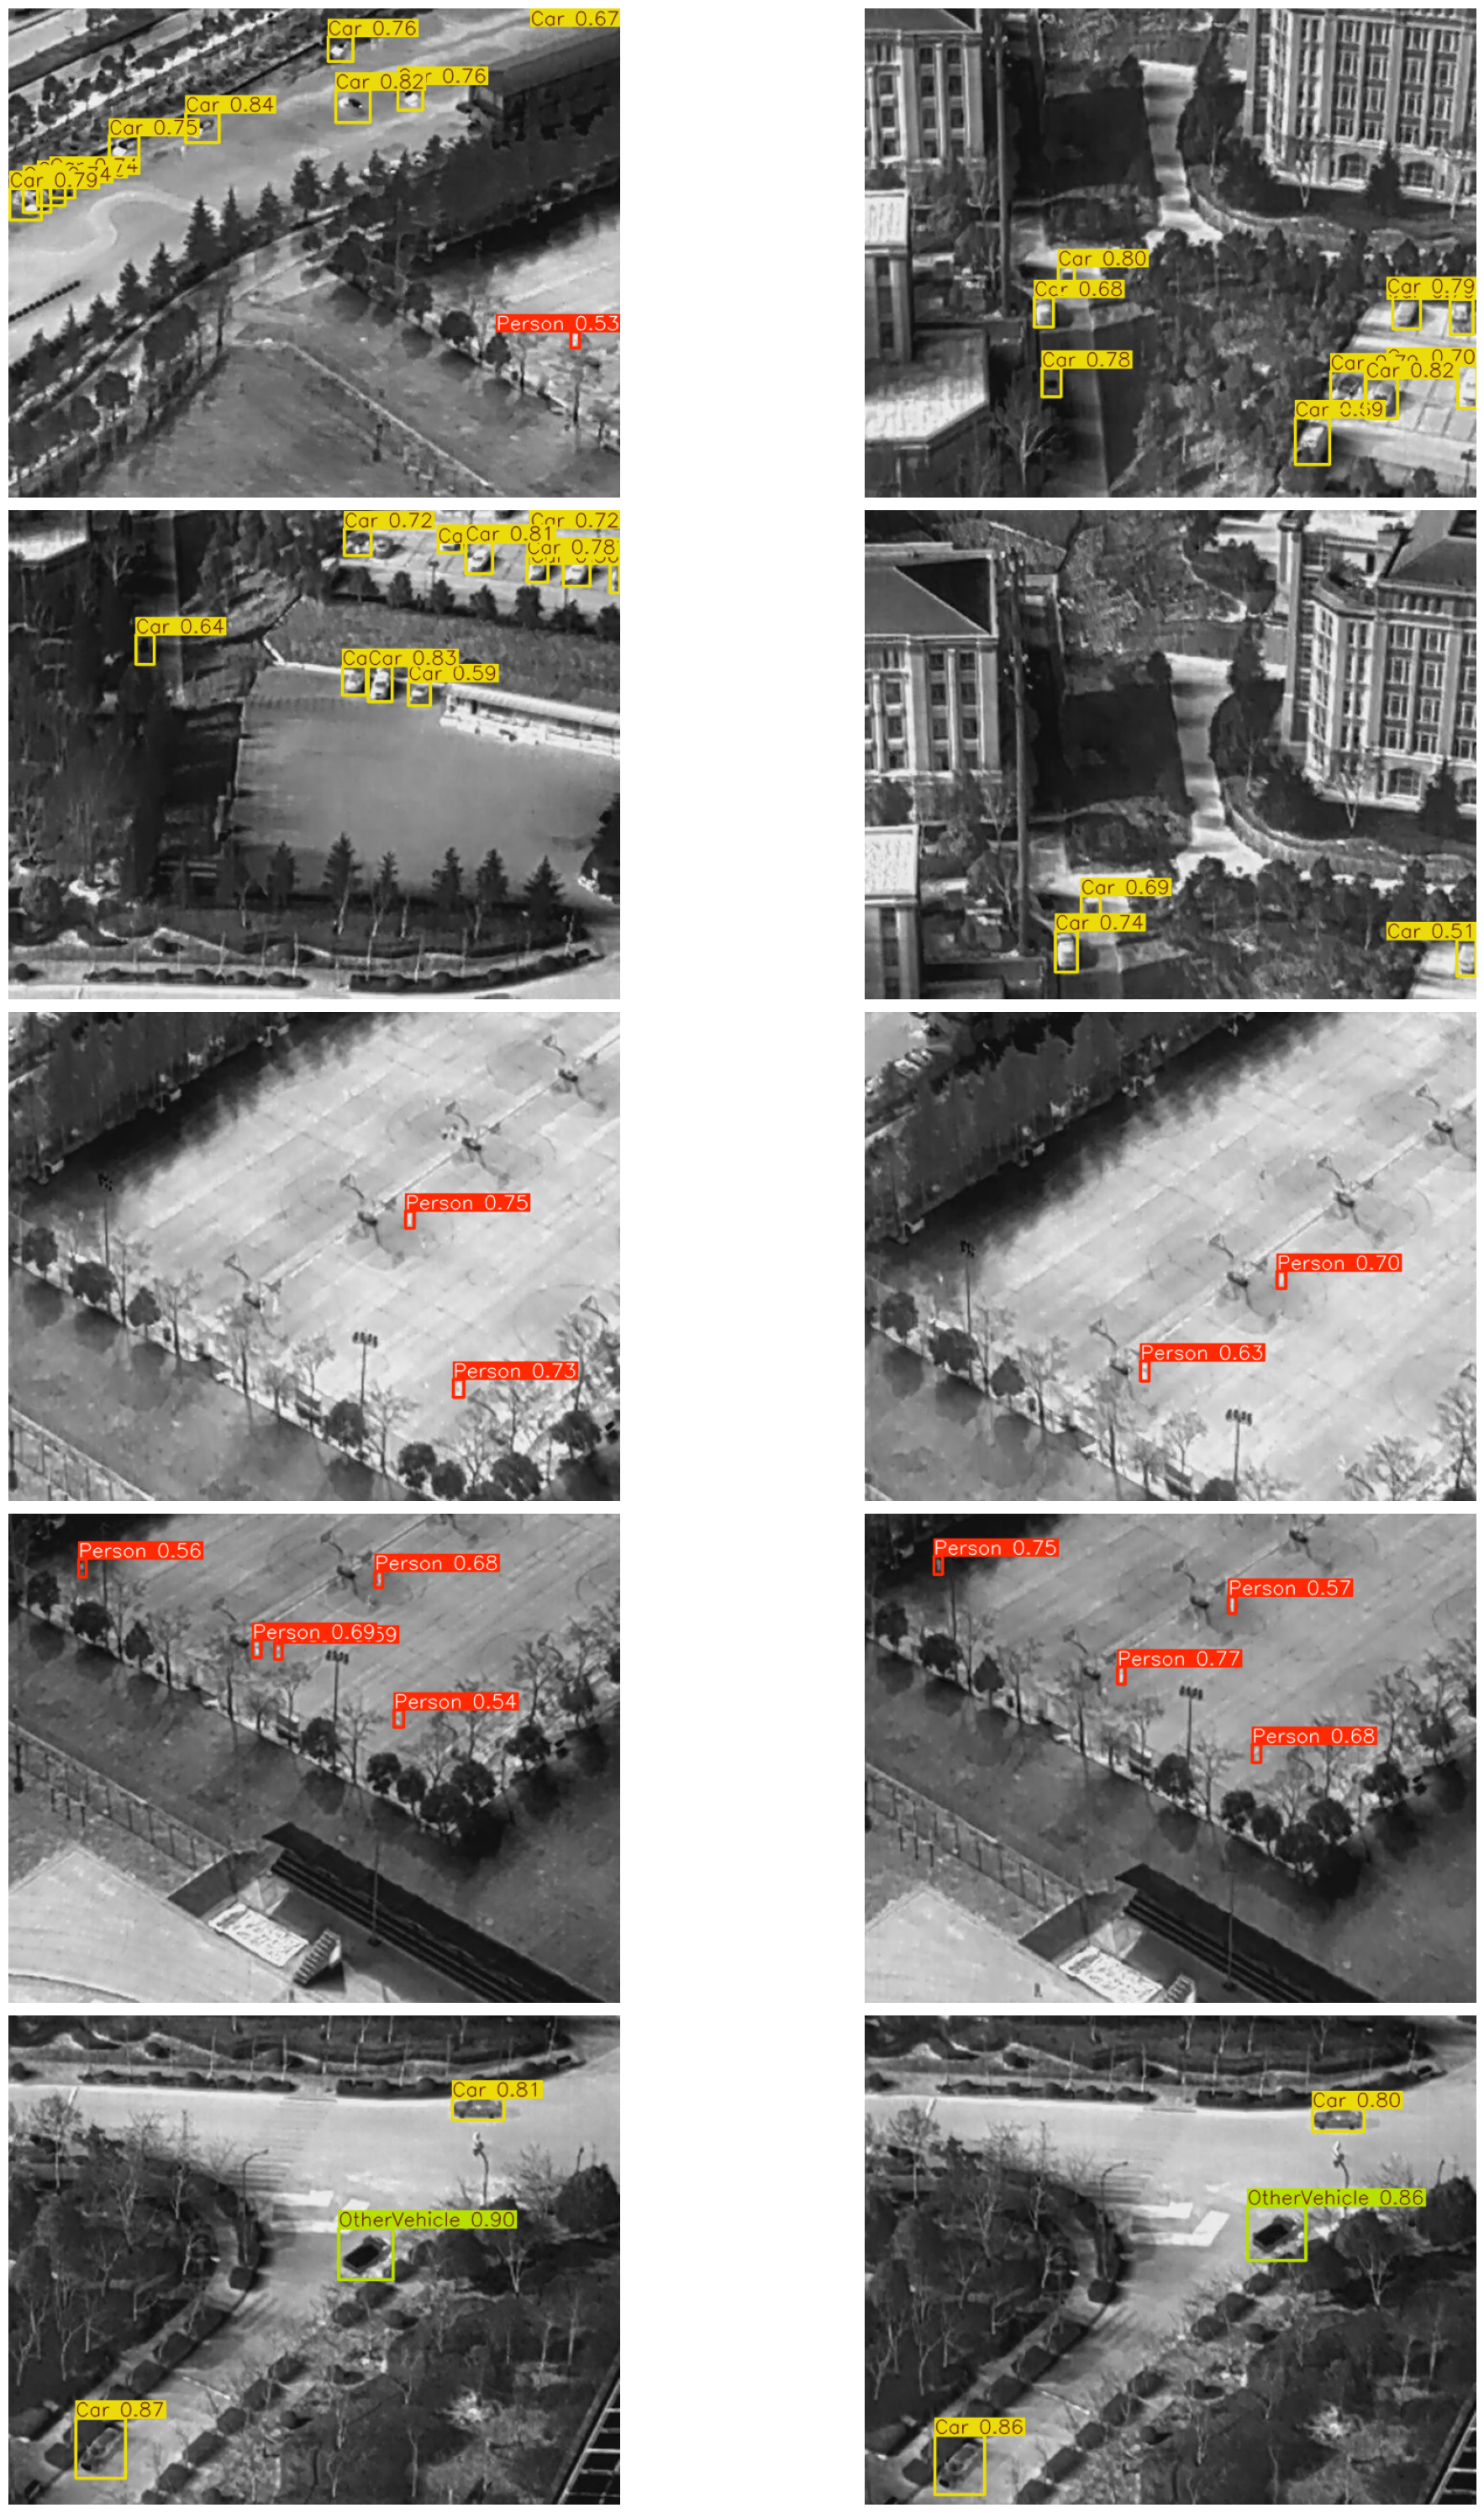

In [44]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [45]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [46]:
!ls runs/detect

predict  train


In [47]:
success = best_efficientnet_model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8-custom summary: 209 layers, 43,841,887 parameters, 0 gradients, 99.6 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (84.1 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 542ms
 Downloaded sympy
 Downloaded onnxruntime-gpu
Prepared 6 packages in 4.24s
Uninstalled 2 packages in 152ms
Installed 6 packages in 53ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.74
 - protobuf==3.20.3
 + protobuf==6.33.1
 - sympy==1.13.1
 + sympy==1.14.0

requirements: AutoUpdate success ✅ 5.4s


'/kaggle/working/runs/detect/train/weights/best.onnx'